In [1]:
import pandas as pd
import glob
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import ntpath
from tslearn.utils import to_time_series
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np

/Users/audi/miniconda3/envs/viz-scripts/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/audi/miniconda3/envs/viz-scripts/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load data

In [2]:
input_dir = "/Users/audi/Downloads/excel in"

In [3]:
def clean(x: object) -> object:
    """Clean a cell value.
    In this case, if it's a string, we will ignore it (i.e. make it nan).

    Parameters
    ----------
    x : object
        Value of a dataframe cell

    Returns
    -------
    object
        nan if it's a string, it's original value otherwise.
    """
    if isinstance(x, str):
        return np.nan
    return x

In [4]:
min_time = -200
max_time = 0

In [45]:
dfs = OrderedDict()
files = glob.glob(os.path.join(input_dir, "*.xlsx"))
files.sort(key=lambda x: int(x.split('/')[-1].split('_')[0]))
for file in files:
    df = pd.read_excel(file, header=0)
    df.set_index(df.columns[0], inplace=True)
    name = ntpath.basename(file).split("equatorial")[0].strip().replace(' ', '_')
    dfs[name] = {}
    for i in range(0, len(df.columns), 6):
        df_slice = df.iloc[:, i:i+6]
        df_slice = df_slice.applymap(clean)
        df_slice = df_slice[(df_slice.index >= min_time) & (df_slice.index <= max_time)]
        film_name = df_slice.columns[0]
        df_slice.columns = list(range(6))
        dfs[name][film_name] = df_slice

In [6]:
print(f'Found {len(dfs.keys())} conditions: {dfs.keys()}')

Found 16 conditions: odict_keys(['0_JDU233_WT_ex_utero', '0_JDU233_WT_in_utero', '1_JDU233_knl-1', '2_JDU233_him-10', '3_JDU233_zwl-1', '4_JDU233_him-10_zwl-1', '5_JDU233_gei-17', '6_JDU233_klp-19', '7_JDU323_WT', '8_JDU323_knl1', '9_JDU323_knl1_him_10', '10_JDU323_knl1_zwl1', '11_JDU574_WT', '12_JDU574_zwl1', '13_JDU574_zwl1_him10', '14_JDU574_zwl1_klp19'])


# Simple statistics

## number of films for each condition
First, we want to see the number of films we have for each condition in our data

In [7]:
nb_films = [len(df.keys()) for _, df in dfs.items()]

<BarContainer object of 16 artists>

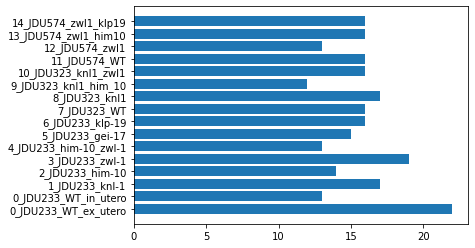

In [8]:
plt.barh(list(dfs.keys()), nb_films)

In [64]:
print(f"Total number of films: {sum(nb_films)}")

Total number of films: 251


## visualizing chromosome distances
Here we just want to see the distribution of the data: the distance of each chromosome in each film at each timestamps. Each line represents one chromosome.

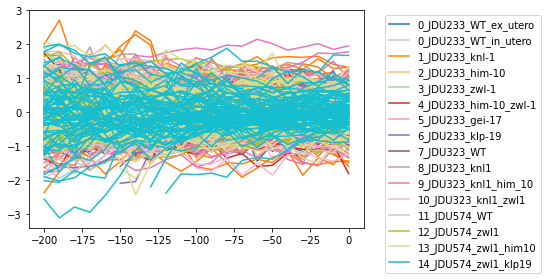

In [202]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        plt.plot(df, color=cm(1.*i/NUM_COLORS), label=cond)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

Note here that the range of the distance is more or less between `-3` to `3`

Let's see an example of just one condition with the least number of films: `9_JDU323_knl1_him_10`:

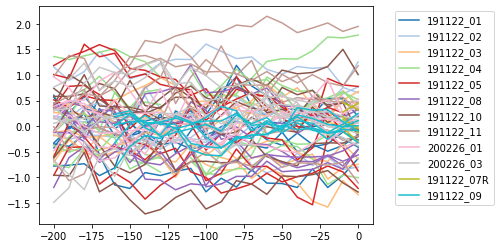

In [203]:
cond = "9_JDU323_knl1_him_10"
films = dfs[cond]
NUM_COLORS = len(films.keys())
for i, (film, df) in enumerate(films.items()):
    plt.plot(df, label=film, color=cm(1.*i/NUM_COLORS), linestyle='-')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

We can see that not all films have the full observations from timestamp `-200` to `0`

## min/max/avg
Next, we want to compute simple statistics of the values: 
- **min** & **max**: for each pole of the spindle, we get the chromosomes that are closest to the each pole and get their distance from the center
- **average**: we get the average distance of each chromosomes to the center, note that we also take into account the sign (+/-), which means if there are the same amount of chromosomes in both sides, each with same distance, the average distance will be 0

### Of each film
For each film on each condition, we get the max/min/avg distance of the chromosomes in that timestamp. Here each line is for one film.

For example, we see below **each solid line** represents the distances of one chromosome in `191122_01` from condition `9_JDU323_knl1_him_10` above, and the **black dotted lines** are the maximum/minimum/average distance for all chromosomes in this film, while the **black dashed line** is the difference between the maximum & the minimum distance.

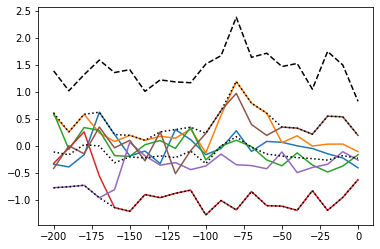

In [39]:
cond = "9_JDU323_knl1_him_10"
film = "191122_01"
df = dfs[cond][film]
plt.plot(df, linestyle='-')
df_max = df.apply(max, axis=1)
df_min = df.apply(min, axis=1)
plt.plot(df_max, color='black', linestyle=':')
plt.plot(df_min, color='black', linestyle=':')
plt.plot(df_max - df_min, color='black', linestyle='--')
plt.plot(df.apply(lambda x: x.mean(), axis=1), color='black', linestyle=':')

Now we compute such max/min/max-min diff/avg values (i.e. the black dotted line) for each of the film on each condition:

Text(0, 0.5, 'Maximum distance')

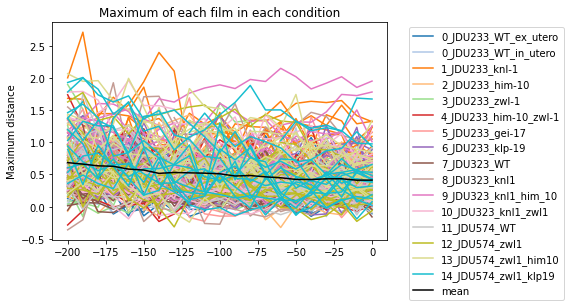

In [68]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_maxes = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        plt.plot(df_max, color=cm(1.*i/NUM_COLORS), label=cond)
        df_maxes.append(df_max)
plt.plot(pd.concat(df_maxes, axis=1).mean(axis=1), color="black", label="mean")        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Maximum of each film in each condition")
plt.ylabel("Maximum distance")

Note above that the range of the value is more or less the *upper* half (`0.5`-`3`) of the overall data (`-3`-`3`). And the descending trend (shown by the `mean`) shows that the chromosomes get closer and closer to the center.

Text(0, 0.5, 'Minimum distance')

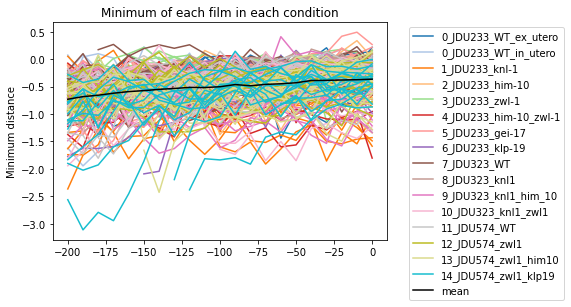

In [70]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_mins = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_min = df.apply(min, axis=1)
        plt.plot(df_min, color=cm(1.*i/NUM_COLORS), label=cond)
        df_mins.append(df_min)
plt.plot(pd.concat(df_mins, axis=1).mean(axis=1), color="black", label="mean")                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Minimum of each film in each condition")
plt.ylabel("Minimum distance")

Note above that the range of the value is more or less the *bottom* half (`-3`-`0.5`) of the overall data (`-3`-`3`), and the increasing trend shows the chromosomes getting closer and closer to the center.

Text(0, 0.5, 'Average distance')

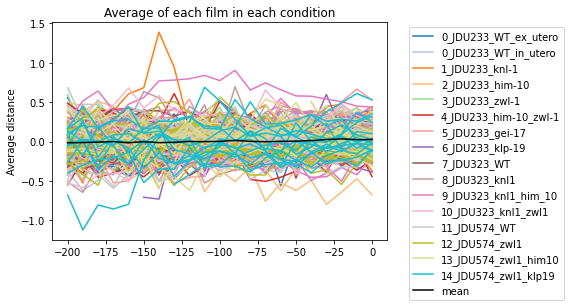

In [71]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_means = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_mean = df.apply(lambda x: x.mean(), axis=1)
        plt.plot(df_mean, color=cm(1.*i/NUM_COLORS), label=cond)
        df_means.append(df_mean)
plt.plot(pd.concat(df_means, axis=1).mean(axis=1), color="black", label="mean")                        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Average of each film in each condition")
plt.ylabel("Average distance")

And as expected, the range of the above is more or less the *middle* half (`-1.5`-`1.5`) of the overall data (`-3`-`3`), and there seems to be a constant trend around `0`, which shows that the chromosomes in both sides more or less move closer to the center simultaneously, i.e. when the maximum decreases, the minimum increases, which is shown by the max & min trends in previous plots.

Text(0, 0.5, 'Max-min distance difference')

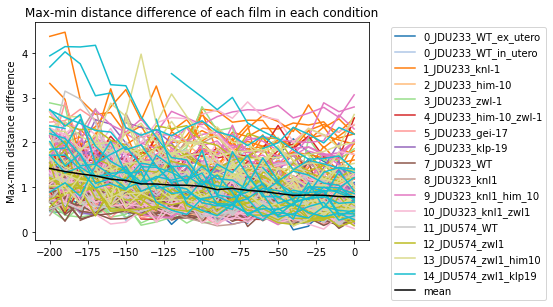

In [73]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_deltas = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_delta = df.apply(max, axis=1)-df.apply(min, axis=1)
        plt.plot(df_delta, color=cm(1.*i/NUM_COLORS), label=cond)
        df_deltas.append(df_delta)
plt.plot(pd.concat(df_deltas, axis=1).mean(axis=1), color="black", label="mean")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Max-min distance difference of each film in each condition")
plt.ylabel("Max-min distance difference")

The range of the value above is always positive (>`0`), as we compute the difference between the maximum & the minimum distance. We see also the decreasing trend here, showing that the chromosomes get closer to each other over time, which we can already assume from the above plots.

### AVG of all films
Now, from the values we compute above (max/min/avg of each film), we want to take an average of those values for each condititions.

For example, we use again the condition `9_JDU323_knl1_him_10`, each **solid line** below represents the maximum values of each film. The **black dotted line** represents the average of those maximums for all films for condition `9_JDU323_knl1_him_10`.

Text(0, 0.5, 'Max distance')

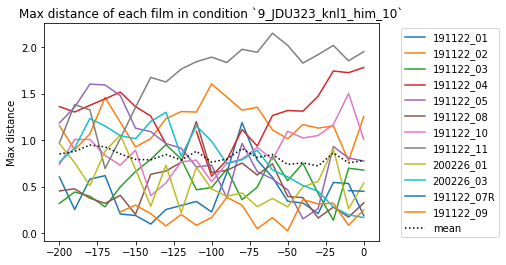

In [84]:
cond = "9_JDU323_knl1_him_10"
df_maxes = []
for film, df in dfs[cond].items():
    df_max = df.apply(max, axis=1)
    plt.plot(df_max, label=film, linestyle='-')
    df_maxes.append(df_max)
plt.plot(pd.concat(df_maxes, axis=1).mean(axis=1), color="black", label="mean", linestyle=":")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Max distance of each film in condition `{cond}`")
plt.ylabel("Max distance")

We compute such average statistics for max/min/avg for each condition below.

Text(0, 0.5, 'Average max distance')

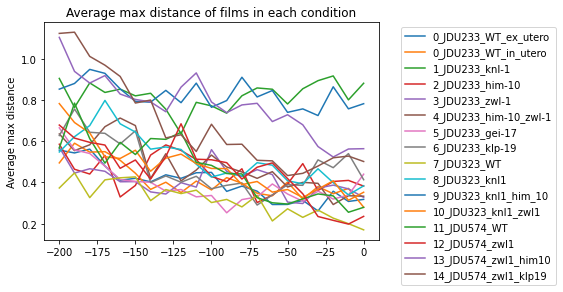

In [87]:
for cond, films in dfs.items():
    df_maxes = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_maxes.append(df_max)
    plt.plot(pd.concat(df_maxes, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average max distance of films in each condition")
plt.ylabel("Average max distance")

Text(0, 0.5, 'Average min distance')

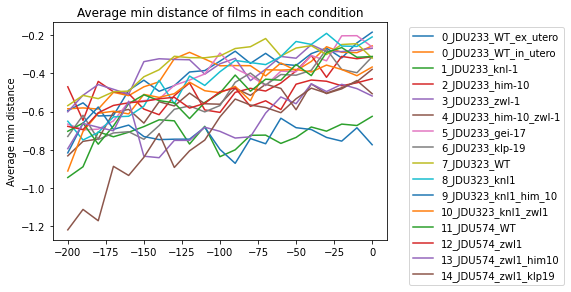

In [88]:
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(min, axis=1)
        df_all.append(df_max)
    plt.plot(pd.concat(df_all, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average min distance of films in each condition")
plt.ylabel("Average min distance")

Text(0, 0.5, 'Average avg distance')

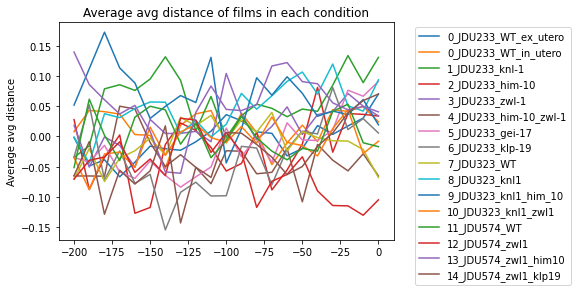

In [89]:
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(lambda x: x.mean(), axis=1)
        df_all.append(df_max)
    plt.plot(pd.concat(df_all, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average avg distance of films in each condition")
plt.ylabel("Average avg distance")

Text(0, 0.5, 'Average max-min distance difference')

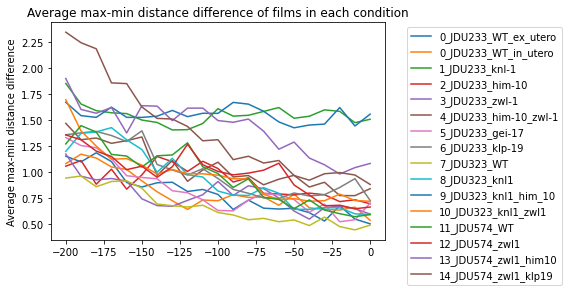

In [90]:
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_min = df.apply(min, axis=1)
        df_delta = df_max - df_min
        df_all.append(df_delta)
    plt.plot(pd.concat(df_all, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average max-min distance difference of films in each condition")
plt.ylabel("Average max-min distance difference")

# Clustering
Here, we would like to compare at how these values move over time (their dynamics) for each condition. In another word, we only want to compare the ***shape*** of each curve in an ***amplitude-invariant*** manner. The fact that it's *amplitude-invariant* means we are only comparing the patterns of **how** these value changes, without taking into account of **how much** they change. 

For example, the two curves below look like their value changes differently over time: 
![Original curves](Unknown)
But after proper scaling, we can see that their value fluctuates in a similar manner:
![Scaled curves](Unknown-2)

For this clustering analysis, we would like to compare the shapes that has been scaled as in the last image above.

## Scaled data
To be precise, we are scaling the curves such that the mean is `0` and the variance (or standard deviation, in this matter) is `1`.

In [143]:
avg_maxs = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_all.append(df_max)
    avg_maxs.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_maxs = np.array(avg_maxs)    

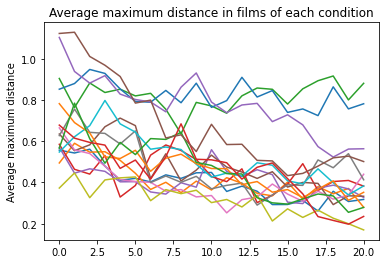

In [144]:
for avg_max in avg_maxs:
    plt.plot(avg_max)
plt.title(f"Average maximum distance in films of each condition")
plt.ylabel("Average maximum distance")

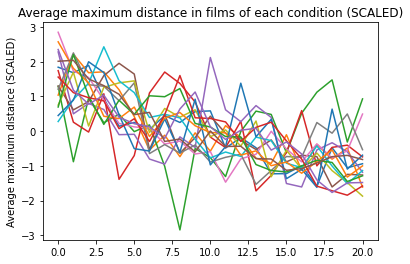

In [145]:
avg_maxs_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_maxs)
for avg_max in avg_maxs_scaled:
    plt.plot(avg_max)
plt.title(f"Average maximum distance in films of each condition (SCALED)")
plt.ylabel("Average maximum distance (SCALED)")

In [146]:
avg_mins = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_min = df.apply(min, axis=1)
        df_all.append(df_min)
    avg_mins.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_mins = np.array(avg_mins)    

Text(0, 0.5, 'Average minimum distance')

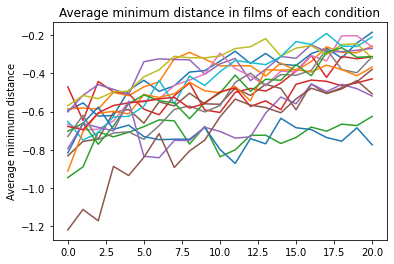

In [147]:
for avg_min in avg_mins:
    plt.plot(avg_min)
plt.title(f"Average minimum distance in films of each condition")
plt.ylabel("Average minimum distance")

Text(0, 0.5, 'Average maximum distance (SCALED)')

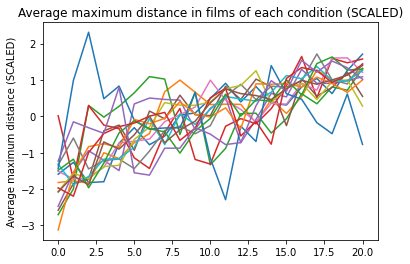

In [148]:
avg_mins_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_mins)
for avg_min in avg_mins_scaled:
    plt.plot(avg_min)
plt.title(f"Average maximum distance in films of each condition (SCALED)")
plt.ylabel("Average maximum distance (SCALED)")

In [154]:
avg_avgs = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_avg = df.apply(lambda x: x.mean(), axis=1)
        df_all.append(df_avg)
    avg_avgs.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_avgs = np.array(avg_avgs)    

Text(0, 0.5, 'Average of average distance')

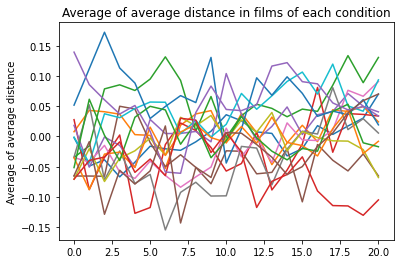

In [155]:
for avg_avg in avg_avgs:
    plt.plot(avg_avg)
plt.title(f"Average of average distance in films of each condition")
plt.ylabel("Average of average distance")

Text(0, 0.5, 'Average of average distance (SCALED)')

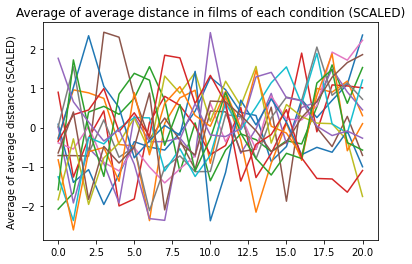

In [156]:
avg_avgs_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_avgs)
for avg_avg in avg_avgs_scaled:
    plt.plot(avg_avg)
plt.title(f"Average of average distance in films of each condition (SCALED)")
plt.ylabel("Average of average distance (SCALED)")

In [97]:
avg_deltas = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_min = df.apply(min, axis=1)
        df_delta = df_max - df_min
        df_all.append(df_delta)
    avg_deltas.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_deltas = np.array(avg_deltas)    

Text(0, 0.5, 'Average max-min distance difference')

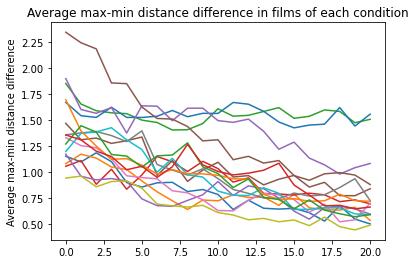

In [149]:
for avg_delta in avg_deltas:
    plt.plot(avg_delta)
plt.title(f"Average max-min distance difference in films of each condition")
plt.ylabel("Average max-min distance difference")

Text(0, 0.5, 'Average max-min distance difference (SCALED)')

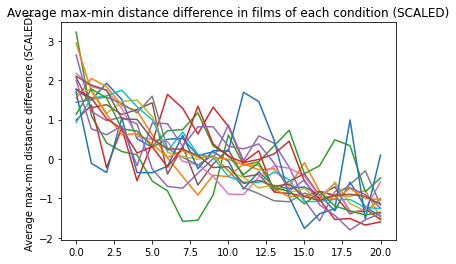

In [150]:
avg_deltas_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_deltas)
for avg_delta in avg_deltas_scaled:
    plt.plot(avg_delta)
plt.title(f"Average max-min distance difference in films of each condition (SCALED)")
plt.ylabel("Average max-min distance difference (SCALED)")

## Clustering
The clustering is done using the [k-means](https://en.wikipedia.org/wiki/K-means_clustering) method, where the computation of distance between to different curves is computed using three different methods:
- [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) (in the case of time series: square root of sum of squared distance on each timestamp)
- [DTW Barycenter Averaging (DBA)](https://www.researchgate.net/publication/220601732_A_global_averaging_method_for_dynamic_time_warping_with_applications_to_clustering)
- [Soft-DTW](https://arxiv.org/abs/1703.01541)

In [159]:
n_cluster = 4

In [188]:
def cluster(X_train, n_cluster=n_cluster, seed=0):
    sz = X_train.shape[1]
    
    y_preds = {}

    # Euclidean k-means
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=n_cluster, verbose=True, random_state=seed)
    y_pred = km.fit_predict(X_train)
    y_preds["Euclidean k-means"] = y_pred

    plt.figure()
    for yi in range(n_cluster):
        plt.subplot(3, n_cluster, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("Euclidean $k$-means")

    # DBA-k-means
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters=n_cluster,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10,
                              random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    y_preds["DBA k-means"] = y_pred

    for yi in range(n_cluster):
        plt.subplot(3, n_cluster, n_cluster+1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("DBA $k$-means")

    # Soft-DTW-k-means
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=n_cluster,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)
    y_preds["Soft-DTW k-means"] = y_pred

    for yi in range(n_cluster):
        plt.subplot(3, n_cluster, 2*n_cluster+1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("Soft-DTW $k$-means")

    plt.tight_layout()
    plt.show()

    return y_preds

### Max

Euclidean k-means
7.832 --> 5.554 --> 5.554 --> 
DBA k-means
Init 1
3.427 --> 2.326 --> 2.326 --> 
Init 2
3.250 --> 2.279 --> 2.279 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
16.491 --> 4.849 --> 4.703 --> 4.698 --> 4.697 --> 4.698 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 


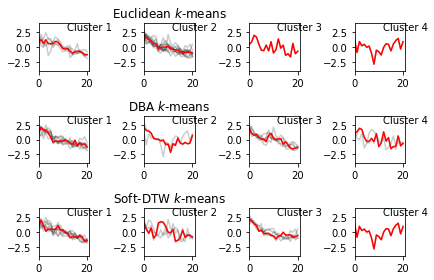

In [161]:
y_preds = cluster(avg_maxs_scaled)

In [172]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
2_JDU233_him-10
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
==== Cluster 2:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
10_JDU323_knl1_zwl1
12_JDU574_zwl1
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 3:
9_JDU323_knl1_him_10
==== Cluster 4:
1_JDU233_knl-1

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
14_JDU574_zwl1_klp19
==== Cluster 2:
1_JDU233_knl-1
5_JDU233_gei-17
==== Cluster 3:
3_JDU233_zwl-1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 4:
2_JDU233_him-10
9_JDU323_knl1_him_10

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 2:
2_JDU233_him-10
3_JDU233_zwl-1
9_JDU323_knl1_him_10
==== Cluster 3:
0_JDU233_WT_ex_utero
5_JDU233_gei-17


Euclidean k-means


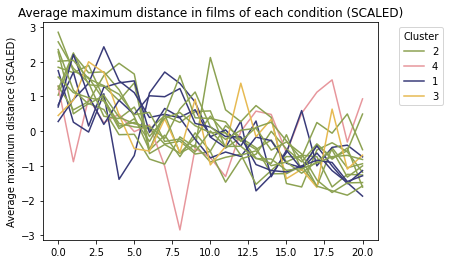

DBA k-means


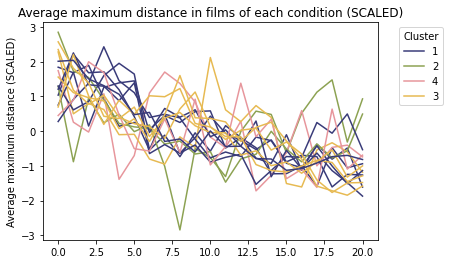

Soft-DTW k-means


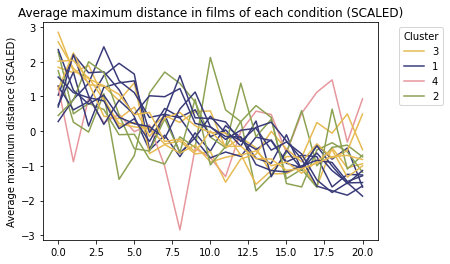

In [189]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_max, clus in zip(avg_maxs_scaled, y_pred):
        plt.plot(avg_max, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average maximum distance in films of each condition (SCALED)")
    plt.ylabel("Average maximum distance (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Min

Euclidean k-means
5.537 --> 3.157 --> 3.088 --> 3.088 --> 
DBA k-means
Init 1
1.952 --> 1.510 --> 1.510 --> 
Init 2
2.196 --> 1.460 --> 1.460 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
5.978 --> 3.661 --> 3.657 --> 3.658 --> 3.671 --> 3.669 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 


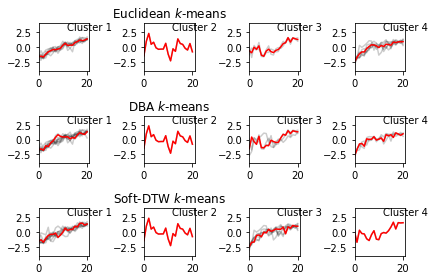

In [190]:
y_preds = cluster(avg_mins_scaled)

In [191]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
5_JDU233_gei-17
6_JDU233_klp-19
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
2_JDU233_him-10
13_JDU574_zwl1_him10
==== Cluster 4:
0_JDU233_WT_in_utero
1_JDU233_knl-1
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
7_JDU323_WT
10_JDU323_knl1_zwl1

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
1_JDU233_knl-1
2_JDU233_him-10
13_JDU574_zwl1_him10
==== Cluster 4:
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
10_JDU323_knl1_zwl1

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
5_JDU233_gei-17
6_JDU233_klp-19
8_JDU323_knl1
11_JDU574_WT
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
1_JDU233_knl-1
3_JDU233_zwl-1
4_JDU233_him-

Euclidean k-means


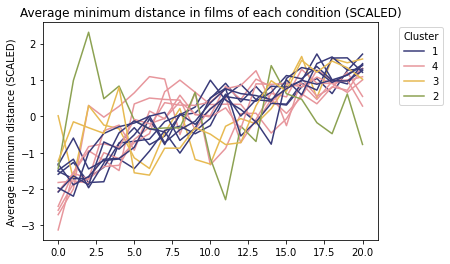

DBA k-means


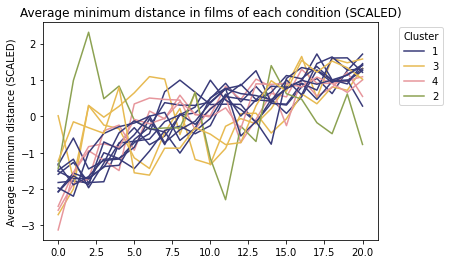

Soft-DTW k-means


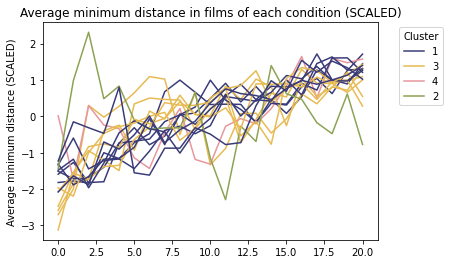

In [192]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_min, clus in zip(avg_mins_scaled, y_pred):
        plt.plot(avg_min, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average minimum distance in films of each condition (SCALED)")
    plt.ylabel("Average minimum distance (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Average

Euclidean k-means
20.697 --> 12.344 --> 12.344 --> 
DBA k-means
Init 1
7.468 --> 5.017 --> 5.017 --> 
Init 2
7.359 --> 4.849 --> 4.849 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
82.320 --> 28.709 --> 28.680 --> 28.645 --> 28.640 --> 28.634 --> 28.633 --> 28.632 --> 28.632 --> 28.631 --> 28.631 --> 28.631 --> 28.631 --> 


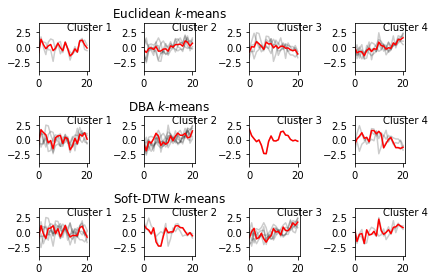

In [197]:
y_preds = cluster(avg_avgs_scaled)

In [198]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
11_JDU574_WT
==== Cluster 2:
1_JDU233_knl-1
6_JDU233_klp-19
8_JDU323_knl1
10_JDU323_knl1_zwl1
13_JDU574_zwl1_him10
==== Cluster 3:
4_JDU233_him-10_zwl-1
7_JDU323_WT
9_JDU323_knl1_him_10
12_JDU574_zwl1
==== Cluster 4:
0_JDU233_WT_ex_utero
2_JDU233_him-10
3_JDU233_zwl-1
5_JDU233_gei-17
14_JDU574_zwl1_klp19

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
2_JDU233_him-10
4_JDU233_him-10_zwl-1
6_JDU233_klp-19
11_JDU574_WT
==== Cluster 2:
0_JDU233_WT_ex_utero
1_JDU233_knl-1
3_JDU233_zwl-1
5_JDU233_gei-17
8_JDU323_knl1
10_JDU323_knl1_zwl1
14_JDU574_zwl1_klp19
==== Cluster 3:
13_JDU574_zwl1_him10
==== Cluster 4:
7_JDU323_WT
9_JDU323_knl1_him_10
12_JDU574_zwl1

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
7_JDU323_WT
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
==== Cluster 3:
0_JDU233_WT_ex_utero
1_JDU233_knl-1
5_JDU233_gei-17
6_JDU233_k

Euclidean k-means


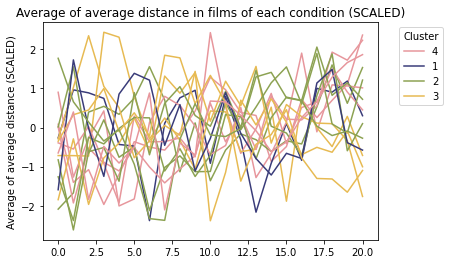

DBA k-means


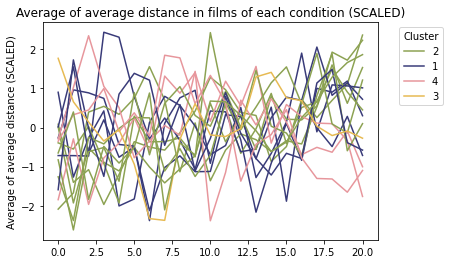

Soft-DTW k-means


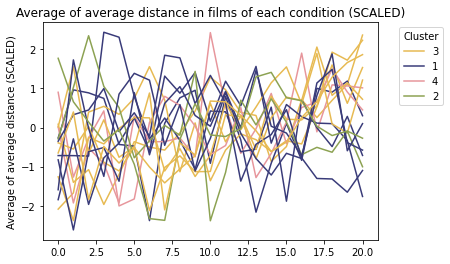

In [199]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_avg, clus in zip(avg_avgs_scaled, y_pred):
        plt.plot(avg_avg, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average of average distance in films of each condition (SCALED)")
    plt.ylabel("Average of average distance (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Max - min

Euclidean k-means
4.001 --> 2.413 --> 2.208 --> 2.208 --> 
DBA k-means
Init 1
1.614 --> 1.159 --> 1.159 --> 
Init 2
1.538 --> 1.059 --> 1.059 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
4.199 --> 1.774 --> 1.772 --> 1.772 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 


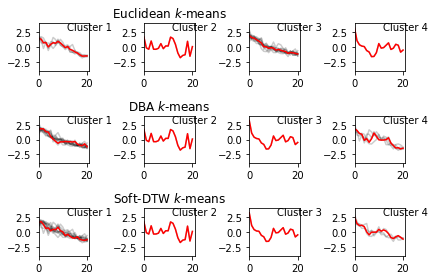

In [193]:
y_preds = cluster(avg_deltas_scaled)

In [194]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
2_JDU233_him-10
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
14_JDU574_zwl1_klp19
==== Cluster 4:
1_JDU233_knl-1

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
1_JDU233_knl-1
==== Cluster 4:
2_JDU233_him-10
3_JDU233_zwl-1
12_JDU574_zwl1
13_JDU574_zwl1_him10

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:


Euclidean k-means


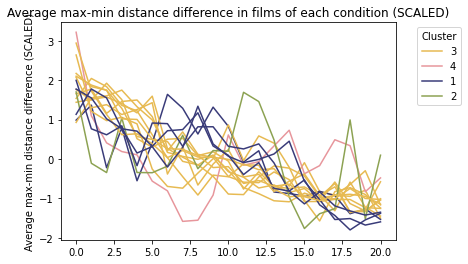

DBA k-means


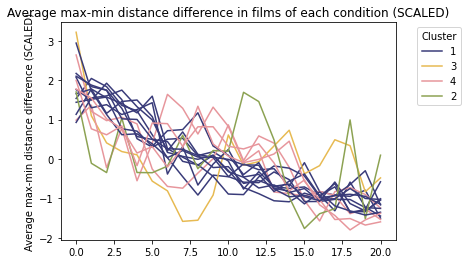

Soft-DTW k-means


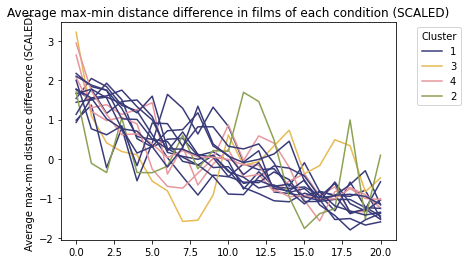

In [195]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_delta, clus in zip(avg_deltas_scaled, y_pred):
        plt.plot(avg_delta, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average max-min distance difference in films of each condition (SCALED)")
    plt.ylabel("Average max-min distance difference (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

#### -200 - -150

In [ ]:
n_cluster=4
X_train = np.array([x[:6] for x in ts_avg_deltas])
y_preds = cluster(X_train, n_cluster=n_cluster)

In [ ]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)

#### -150 - -100

In [ ]:
n_cluster=4
X_train = np.array([x[6:11] for x in ts_avg_deltas])
y_preds = cluster(X_train, n_cluster=n_cluster)

In [ ]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)

#### -100 - -50

In [ ]:
n_cluster=4
X_train = np.array([x[11:16] for x in ts_avg_deltas])
y_preds = cluster(X_train, n_cluster=n_cluster)

In [ ]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)

#### -50 - 0

In [ ]:
n_cluster=4
X_train = np.array([x[16:] for x in ts_avg_deltas])
y_preds = cluster(X_train, n_cluster=n_cluster)

In [ ]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)

### Avg

In [ ]:
X_train = np.array(ts_avg_avgs)
y_preds = cluster(X_train)

In [ ]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)

# statsmodels

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf